In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import louvain
import igraph as ig

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
# from scipy.stats import pearsonr

from snmcseq_utils import plot_tsne_labels

In [16]:
# import real data

# mCC
data_f = '/cndd/fangming/snmcseq_dev/data/binc/binc_mCH_human_combined_100000_summary_nmcc_v3.tsv'
data_f = '/cndd/fangming/snmcseq_dev/data/binc/binc_mCG_human_combined_100000_summary_nmcc_v3.tsv'
data_f = '/cndd/fangming/snmcseq_dev/data/binc/binc_mCHmCG_human_combined_100000_summary_nmcc_v3.tsv'
df = pd.read_table(data_f, index_col=['chr', 'bin'], dtype={'chr': object})
print(df.shape)
df = df.T
print(df.shape)

(49080, 6435)
(6435, 49080)


In [23]:
# import tSNE coords

# tsne
tsne_f = '/cndd/fangming/snmcseq_dev/data/tsne/tsne_perp30_binc_mCH_human_combined_100000_summary_nmcc_v3.tsv'
# tsne_f = '/cndd/fangming/snmcseq_dev/data/tsne/tsne_perp30_binc_mCG_human_combined_100000_summary_nmcc_v3.tsv'
# tsne_f = '/cndd/fangming/snmcseq_dev/data/tsne/tsne_perp30_binc_mCHmCG_human_combined_100000_summary_nmcc_v3.tsv'
df_tsne = pd.read_table(tsne_f, index_col='sample')
print(df_tsne.shape)

(6435, 2)


# louvain clustering from kNN graph
# 2 parameters: # of PCs and # of nearest neighbors

(6435, 50)


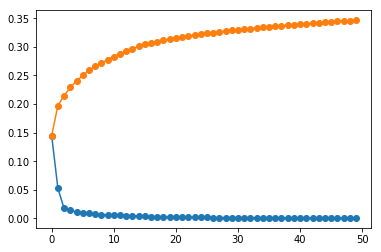

In [18]:
# pca
pca = PCA(n_components=50).fit(df.values)
pcs = pca.transform(df.values)
print(pcs.shape)


# scree plot 
fig, ax = plt.subplots()
ax.plot(pca.explained_variance_ratio_, '-o')
ax.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
plt.show()


In [19]:
# jaccard index 
def compute_jaccard(x, y):
    """
    Compute the jaccard index for 2 boolean arrays
    """
    x = np.asarray(x).astype(np.bool)
    y = np.asarray(y).astype(np.bool)
    assert x.shape == y.shape

    intersection = np.logical_and(x, y)
    union = np.logical_or(x, y)
    
    return intersection.sum()/float(union.sum()) 
    
def compute_jaccard_weights_old(X):
    """
    Given an (unweighted) ajacency matrix, assign jaccard index as weights
    
    X is unsymmetric and 0-1 valued 
    """
    X = np.asarray(X)
    Y = np.zeros(X.shape)
    
    # non-zero element index (i, j)
    for i, j in zip(*np.nonzero(X)): 
        Y[i,j] = compute_jaccard(X[i, :], X[j, :])
    return Y

def compute_jaccard_weights(X, option='DIRECTED'):
    """
    Given an (unweighted) ajacency matrix, assign jaccard index as weights
    
    X has to be 0-1 valued 
    """
    X = np.asarray(X)
    ni, nj = X.shape
    assert ni == nj
    
    Y = np.dot(X, X.T)/(ni - np.dot((X-1), (X-1).T))
    
    if option == 'DIRECTED':
        # only set weight in places where X are nonzero
        Y = Y*X
    elif option == 'UNDIRECTED':
        Y = Y*((X+X.T)>0)
    else:
        raise ValueError('choose DIRECTED or UNDIRECTED')
    return Y

# louvain clustering
def louvain_clustering(adj_mtx, index, option='DIRECTED'):
    """
    a wrap-up function for louvain clustering given a (weighted) adjacency matrix
    """
    G = ig.Graph.Weighted_Adjacency(adj_mtx.tolist(), mode=option)
    louvain.set_rng_seed(1)
    partition1 = louvain.find_partition(G, louvain.ModularityVertexPartition, weights=G.es["weight"])

    labels = [0]*index.shape[0] 
    for i, cluster in enumerate(partition1):
        for element in cluster:
            labels[element] = 'cluster_' + str(i+1)
        
    df_res = pd.DataFrame(index=[idx[:-len('_mcc')] for idx in index])
    df_res['cluster_ID'] = labels 
    df_res = df_res.rename_axis('sample', inplace=True)
    return df_res


In [20]:
### build a jaccard-index weighted k nearest neighbor graph
ti = time.time()

# get 0-1 adjacency matrix of kNN 
knn = NearestNeighbors(n_neighbors=30, metric='euclidean').fit(pcs)
g_knn = knn.kneighbors_graph(pcs, mode='connectivity')
g_knn = g_knn.toarray()

# verify results
# print(g_knn.shape)
# print(np.sum(g_knn, axis=1))

# get weights 
gw_knn = compute_jaccard_weights(g_knn, option='DIRECTED')

# adjacency matrix used for louvain clustering
adj_mtx = gw_knn

tf = time.time()
print(tf - ti)

4.375336647033691


In [21]:
ti = time.time()
df_res = louvain_clustering(adj_mtx, df.index, option='DIRECTED')
tf = time.time()
print(tf - ti)
# df_res['cluster_ordered'] = [int(cluster_ID[len('cluster_'):]) for cluster_ID in df_res.cluster_ID]
df_res.head()

3.768526077270508


,cluster_ID
sample,
160729_MB_v1_hs_25yr_MFG_pool_1000_AD008_indexed,cluster_8
160729_MB_v1_hs_25yr_MFG_pool_1000_AD010_indexed,cluster_6
160729_MB_v1_hs_25yr_MFG_pool_1001_AD008_indexed,cluster_6
160729_MB_v1_hs_25yr_MFG_pool_1001_AD010_indexed,cluster_1
160729_MB_v1_hs_25yr_MFG_pool_1002_AD010_indexed,cluster_25


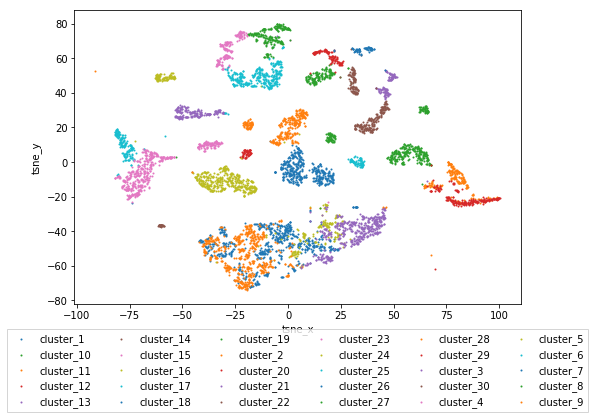

In [24]:
df_plot = pd.merge(df_tsne, df_res, left_index=True, right_index=True)
# df_plot.head()
plot_tsne_labels(df_plot, tc='cluster_ID', legend_mode=1)

# output

In [295]:
df_res.to_csv('/cndd/fangming/snmcseq_dev/data/cluster/cluster_MB_v1_MB_EA_MB_EB/clusters_v2_binc_mCH_louvain.tsv',
             sep='\t', na_rep='NA', header=True, index=True)

Saved to /cndd/fangming/snmcseq_dev/results/tsne_clusters/tsne_cluster_MB_v1_MB_EA_MB_EB_cluster_v1.pdf


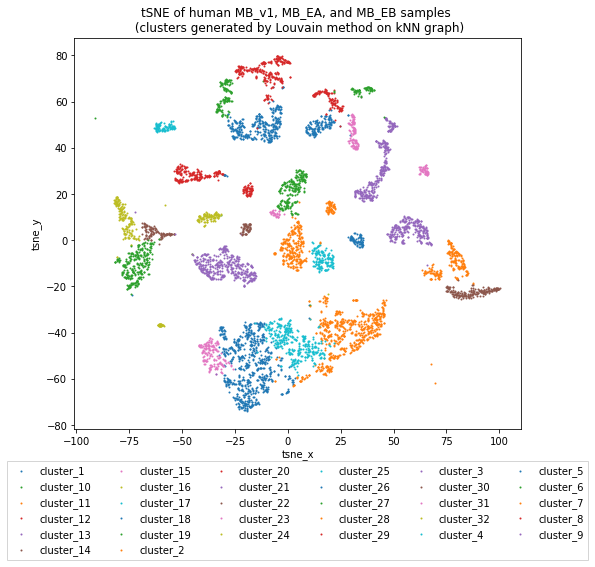

In [298]:
plot_tsne_labels(df_plot, tc='cluster_ID', 
    title='tSNE of human MB_v1, MB_EA, and MB_EB samples \n (clusters generated by Louvain method on kNN graph)', 
    figsize=(8,8), legend_mode=1,
    output='/cndd/fangming/snmcseq_dev/results/tsne_clusters/tsne_cluster_MB_v1_MB_EA_MB_EB_cluster_v1.pdf'
    )